In [29]:
import pandas as pd
import requests
import json
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv
import os

# Load environment variables from a .env file
load_dotenv()

# Pandas settings for better display in PyCharm
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# CREDENTIALS
API_URL = os.getenv("API_URL")
API_KEY = os.getenv("API_KEY")
CLEAN_DATA_PATH = "data/dataset_raids_clean.csv"

print("[+] Libs loaded and settings configured.")

[+] Libs loaded and settings configured.


In [30]:
def get_data_from_api(action_type):
    print(f"[+] Connecting to {API_URL}...")
    try:
        response = requests.get(
            API_URL,
            headers={"Authorization": f"Bearer {API_KEY}"},
            params={"action": action_type}
        )
        if response.status_code == 200:
            data = response.json()
            print(f"[+] Received {len(data)} events.")
            return data
        else:
            print(f"[-] API ERROR: {response.status_code} - {response.text}")
            return []
    except Exception as e:
        print(f"[-] Connexion error: {e}")
        return []

In [31]:
# Download
raw_data = get_data_from_api("RAID_INTERACTION")

if raw_data:
    # Create DataFrame
    df = pd.DataFrame(raw_data)

    # 'context_data' column cleaning
    def clean_json(x):
        if isinstance(x, dict): return x
        try: return json.loads(x)
        except: return {}

    df['context_data'] = df['context_data'].apply(clean_json)

    # Flatten the 'context_data' JSON column
    df_context = pd.json_normalize(df['context_data'])

    # Search for duplicated columns between SQL table and JSON
    duped_columns = df_context.columns.intersection(df.columns)

    # We remove them from the JSON DataFrame because the main table ones are more reliable
    if not duped_columns.empty:
        print(f"[INFO] Deleting duped columns from JSON: {list(duped_columns)}")
        df_context = df_context.drop(columns=duped_columns)

    # Join and drop original JSON column
    df_final = df.join(df_context).drop(columns=['context_data'])

    # -----------------------------------------------------------
    # CRITICAL FIX: Swap World and Biome columns
    # The Java mod sends these inverted for Raids. We fix it here.
    # -----------------------------------------------------------
    print("[INFO] Applying fix for swapped World/Biome columns...")

    # We copy the series to avoid reference issues
    real_worlds = df_final['biome'].copy() # Biome column actually contains the World
    real_biomes = df_final['world'].copy() # World column actually contains the Biome

    df_final['world'] = real_worlds
    df_final['biome'] = real_biomes

    print(f"[INFO] Verification -> World: {df_final['world'].iloc[0]} | Biome: {df_final['biome'].iloc[0]}")

    # -----------------------------------------------------------
    # SERVER PROCESSING
    # Convert 'xerneas'/'yveltal' strings into One-Hot Encoded columns
    # -----------------------------------------------------------
    if 'server_id' in df_final.columns:
        print("[INFO] Processing Server IDs...")
        server_dummies = pd.get_dummies(df_final['server_id'], prefix='server')
        # Join the new boolean columns to the main dataframe
        df_final = pd.concat([df_final, server_dummies], axis=1)

    # Create Target (Objective)
    if 'result' in df_final.columns:
        df_final['target'] = df_final['result'].apply(lambda x: 1 if x == 'WIN' else 0)

    # Filter only useful columns for the AI (Cleanup)
    cols_to_keep = [
        'target',
        'bossSpecies',
        'participantsCount',
        'damageDealt',
        'world',
        'biome',
        'result' # Kept for visualization in next cell
    ]
    # Dynamically add the server columns (e.g., server_xerneas)
    cols_to_keep.extend([col for col in df_final.columns if 'server_' in col])

    # Update df_final to only contain clean data
    df_final = df_final[cols_to_keep].copy()

    print("[+] Data processed and corrected:")
    display(df_final.head())
else:
    print("[-] There is any data to process.")

[+] Connecting to http://node-marb.ponchisaohosting.xyz:25589/api/training-data...
[+] Received 41 events.
[INFO] Deleting duped columns from JSON: ['world', 'biome', 'timestamp']
[INFO] Applying fix for swapped World/Biome columns...
[INFO] Verification -> World: cobblemonraiddens:89f5c260-c903-413f-a6ae-71793a231ad0 | Biome: cobblemonraiddens:raid_den
[INFO] Processing Server IDs...
[+] Data processed and corrected:


,target,bossSpecies,participantsCount,damageDealt,world,biome,result,server_id,server_xerneas,server_yveltal
0,1,Wormadam,1,0,cobblemonraiddens:89f5c260-c903-413f-a6ae-7179...,cobblemonraiddens:raid_den,WIN,yveltal,False,True
1,1,Litleo,1,0,cobblemonraiddens:89f5c260-c903-413f-a6ae-7179...,cobblemonraiddens:raid_den,WIN,yveltal,False,True
2,1,Nickit,1,0,cobblemonraiddens:89f5c260-c903-413f-a6ae-7179...,cobblemonraiddens:raid_den,WIN,yveltal,False,True
3,1,Chansey,1,0,cobblemonraiddens:89f5c260-c903-413f-a6ae-7179...,cobblemonraiddens:raid_den,WIN,yveltal,False,True
4,1,Drifblim,1,0,cobblemonraiddens:89f5c260-c903-413f-a6ae-7179...,cobblemonraiddens:raid_den,WIN,yveltal,False,True


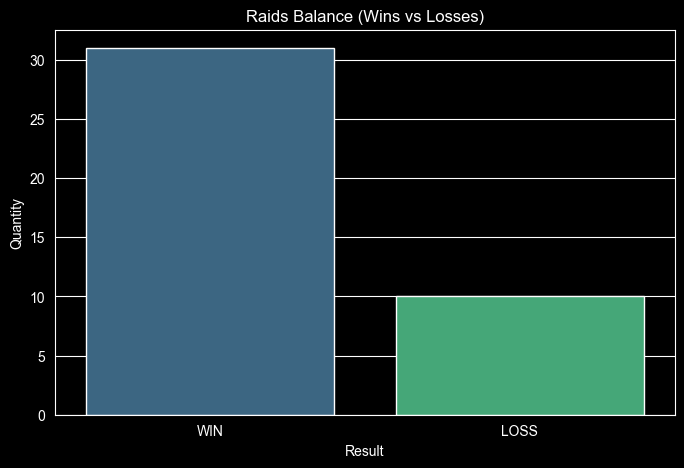

[+] Victory Rate: 75.61%


In [33]:
if 'target' in df_final.columns:
    plt.figure(figsize=(8, 5))

    # Plotting the count of wins and losses
    sns.countplot(x='result', hue='result', data=df_final, palette='viridis', legend=False)

    plt.title('Raids Balance (Wins vs Losses)')
    plt.xlabel('Result')
    plt.ylabel('Quantity')
    plt.show()

    print(f"[+] Victory Rate: {df_final['target'].mean() * 100:.2f}%")

In [35]:
# Ensure data directory exists
if not os.path.exists('data'):
    os.makedirs('data')
    print("[+] Created 'data' directory.")

if not df_final.empty:
    df_final.to_csv(CLEAN_DATA_PATH, index=False)
    print(f"[+] File '{CLEAN_DATA_PATH}' saved correctly.")

[+] Created 'data' directory.
[+] File 'data/dataset_raids_clean.csv' saved correctly.
